In [20]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils import load_jsonl

pd.options.display.float_format = "{:.3f}".format

In [21]:
tournament_file = "./tournaments/rakuda_v1.jsonl"

In [22]:
charts_prefix = "./charts/" + tournament_file.split("/")[-1].split(".")[0]

# Load the matches

In [23]:
with open(tournament_file, 'r') as f:
    tournament = json.load(f)

In [24]:
df = pd.DataFrame(tournament['matches'])
df = df[["model1_id", "model2_id", "score"]]

In [25]:
df.sample(5)  # score 1 -> model 1 victory, 2 -> model 2 victory, 3 -> draw

,model1_id,model2_id,score
1004,cyberagent/open-calm-7b,gpt-3.5-turbo-0301:20230614,2
1090,cyberagent/open-calm-7b,rinna/japanese-gpt-neox-3.6b-instruction-sft-v2,2
1106,cyberagent/open-calm-7b,rinna/japanese-gpt-neox-3.6b-instruction-sft-v2,1
451,rinna/japanese-gpt-neox-3.6b-instruction-sft-v2,cyberagent/open-calm-7b,1
14,gpt-3.5-turbo-0301:20230614,rinna/japanese-gpt-neox-3.6b-instruction-ppo,1


##  Defining useful data quantities

In [26]:
# A mapping from a model to an integer index for convenience
model_to_int = {
    x: i
    for i, x in enumerate(
        df.groupby(["model1_id", "model2_id"]).size().unstack(fill_value=0).index
    )
}

int_to_model = {integer: model for model, integer in model_to_int.items()}

In [27]:
int_to_model

{0: 'cyberagent/open-calm-7b',
 1: 'gpt-3.5-turbo-0301:20230614',
 2: 'izumi-lab/stormy-7b-10ep',
 3: 'rinna/japanese-gpt-neox-3.6b',
 4: 'rinna/japanese-gpt-neox-3.6b-instruction-ppo',
 5: 'rinna/japanese-gpt-neox-3.6b-instruction-sft-v2'}

In [28]:
# Number of models
N = len(int_to_model)
# Number of matches
M = len(df)

print(f"{N} models played {M} matches")

6 models played 1200 matches


In [29]:
# Score vector
Y_m = (
    1 - (df["score"] - 1) / 2
).values  # 1 if i_m beat j_m in the mth game, .5 for a time, 0 otherwise

# match vectors: who played in the ith match
i_m = df.apply(lambda row: model_to_int[row["model1_id"]], axis=1).values
j_m = df.apply(lambda row: model_to_int[row["model2_id"]], axis=1).values

## Define the model

We model the probability that model $i$ in the first position beats model $j$ in the second position as 

$p_{ij} = \dfrac{e^{\alpha+\beta_i - \beta_j}}{1+e^{\alpha+\beta_i-\beta_j}}$

where $\beta_i$ is the strength of model $i$ and $\alpha$ is a home field advantage parameter that is greater than 0 if the model in the first position is favored over the model in the second position and is less than 0 if the second model is favored. Draws are counted as a half-win for each teams.

The log likelihood of the data given the parameters is then (see, e.g. https://web.stanford.edu/class/archive/stats/stats200/stats200.1172/Lecture24.pdf)

In [30]:
def l(alpha, betas, Y_m, i_m, j_m):
    betas_diff = betas[i_m] - betas[j_m]
    return np.sum(Y_m * (alpha + betas_diff) - np.log1p(np.exp(alpha + betas_diff)))

And the partial derivatives of the log likelihood with respect to the parameters are

In [31]:
def dldalpha(alpha, betas, Y_m, i_m, j_m):
    betas_diff = betas[i_m] - betas[j_m]
    exp_term = np.exp(alpha + betas_diff)
    dldalpha = np.sum(Y_m - exp_term / (1 + exp_term))
    return dldalpha

In [32]:
def dldbetai(alpha, betas, Y_m, i_m, j_m, i):
    betas_diff = betas[i_m] - betas[j_m]
    exp_term = np.exp(alpha + betas_diff)
    term = Y_m - exp_term / (1 + exp_term)

    dldbetai = np.sum(term[i_m == i]) - np.sum(term[j_m == i])
    return dldbetai

## We find the point in parameter space that maximizes the likelihood using scipy.optimize

In [33]:
import numpy as np
from scipy.optimize import minimize

# Initial guess for the parameters
x0 = np.zeros(N+1)

# Maximum number of iterations
max_iter = 1000

# Tolerance for stopping criteria
tol = 1e-6

# Define the system of equations
def F(x):
    return -l(x[0], x[1:], Y_m, i_m, j_m) + np.sum(x[:1]) ** 2

max_likelihood = minimize(F, x0)
print(f"Maximum Likelihood Solution is {max_likelihood}")
print(f"Beta sum: {np.sum(max_likelihood.x[1:])}")

Maximum Likelihood Solution is       fun: 710.4459701043005
 hess_inv: array([[ 4.22707640e-03, -7.32330310e-05,  1.18709606e-03,
        -3.49422340e-04, -5.52811642e-04, -4.29414875e-04,
        -4.87982248e-04],
       [-7.32330310e-05,  1.75142937e-01,  1.64779426e-01,
         1.65020891e-01,  1.64991853e-01,  1.64988990e-01,
         1.65191643e-01],
       [ 1.18709606e-03,  1.64779426e-01,  1.76033998e-01,
         1.64620185e-01,  1.64576746e-01,  1.64612465e-01,
         1.64781798e-01],
       [-3.49422340e-04,  1.65020891e-01,  1.64620185e-01,
         1.74979602e-01,  1.64942499e-01,  1.64975042e-01,
         1.65149166e-01],
       [-5.52811642e-04,  1.64991853e-01,  1.64576746e-01,
         1.64942499e-01,  1.75089708e-01,  1.64933353e-01,
         1.65182922e-01],
       [-4.29414875e-04,  1.64988990e-01,  1.64612465e-01,
         1.64975042e-01,  1.64933353e-01,  1.74980650e-01,
         1.65165299e-01],
       [-4.87982248e-04,  1.65191643e-01,  1.64781798e-01,
      

## To quantify our confidence in these parameter values we run Markov Chain Monte Carlo using emcee

In [56]:
import emcee

# Parameter space dimension
ndim = N + 1

# Number of independent chains
nwalkers = 32

# Number of samples per chain
nsamples = 20000

#
def log_prior(x):
    if -1 < x[0] < 1 and all([-2<beta<2 for beta in x[1:]]):
        return 0.0
    return -np.inf

# Log Probability = Log_Prior + Log Likelihood
def log_probability(x):
    lp = log_prior(x)
    if not np.isfinite(lp):
        return -np.inf
    return lp + l(x[0], x[1:], Y_m, i_m, j_m) - np.sum(x[1:]) ** 2

# Initialize the walkers randomly around the MLE point 
p0 = np.random.normal(max_likelihood.x, .1, (nwalkers, ndim))

# Define the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

# Run the MCMC
# this doesn't take more than like a minute to run. if too slow just reduce the nsamples/nwalkers, current numbers are overkill
sampler.run_mcmc(p0, nsamples);

In [57]:
print("Mean acceptance fraction: {0:.2f}".format(np.mean(sampler.acceptance_fraction)))
print(
    "Mean autocorrelation time: {0:.0f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean acceptance fraction: 0.49
Mean autocorrelation time: 84 steps


In [58]:
# Burn the first 1000 steps per chain to erase initial conditions 
flat_samples = sampler.get_chain(discard=1000, flat=True)
print(flat_samples.shape)

(608000, 7)


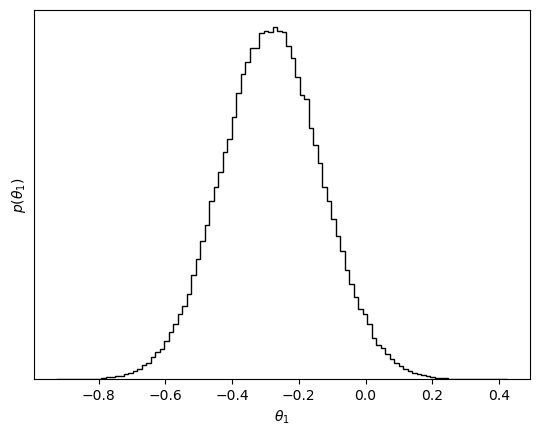

In [59]:
# Plot a parameter distribution
import matplotlib.pyplot as plt

plt.hist(flat_samples[:, 4], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

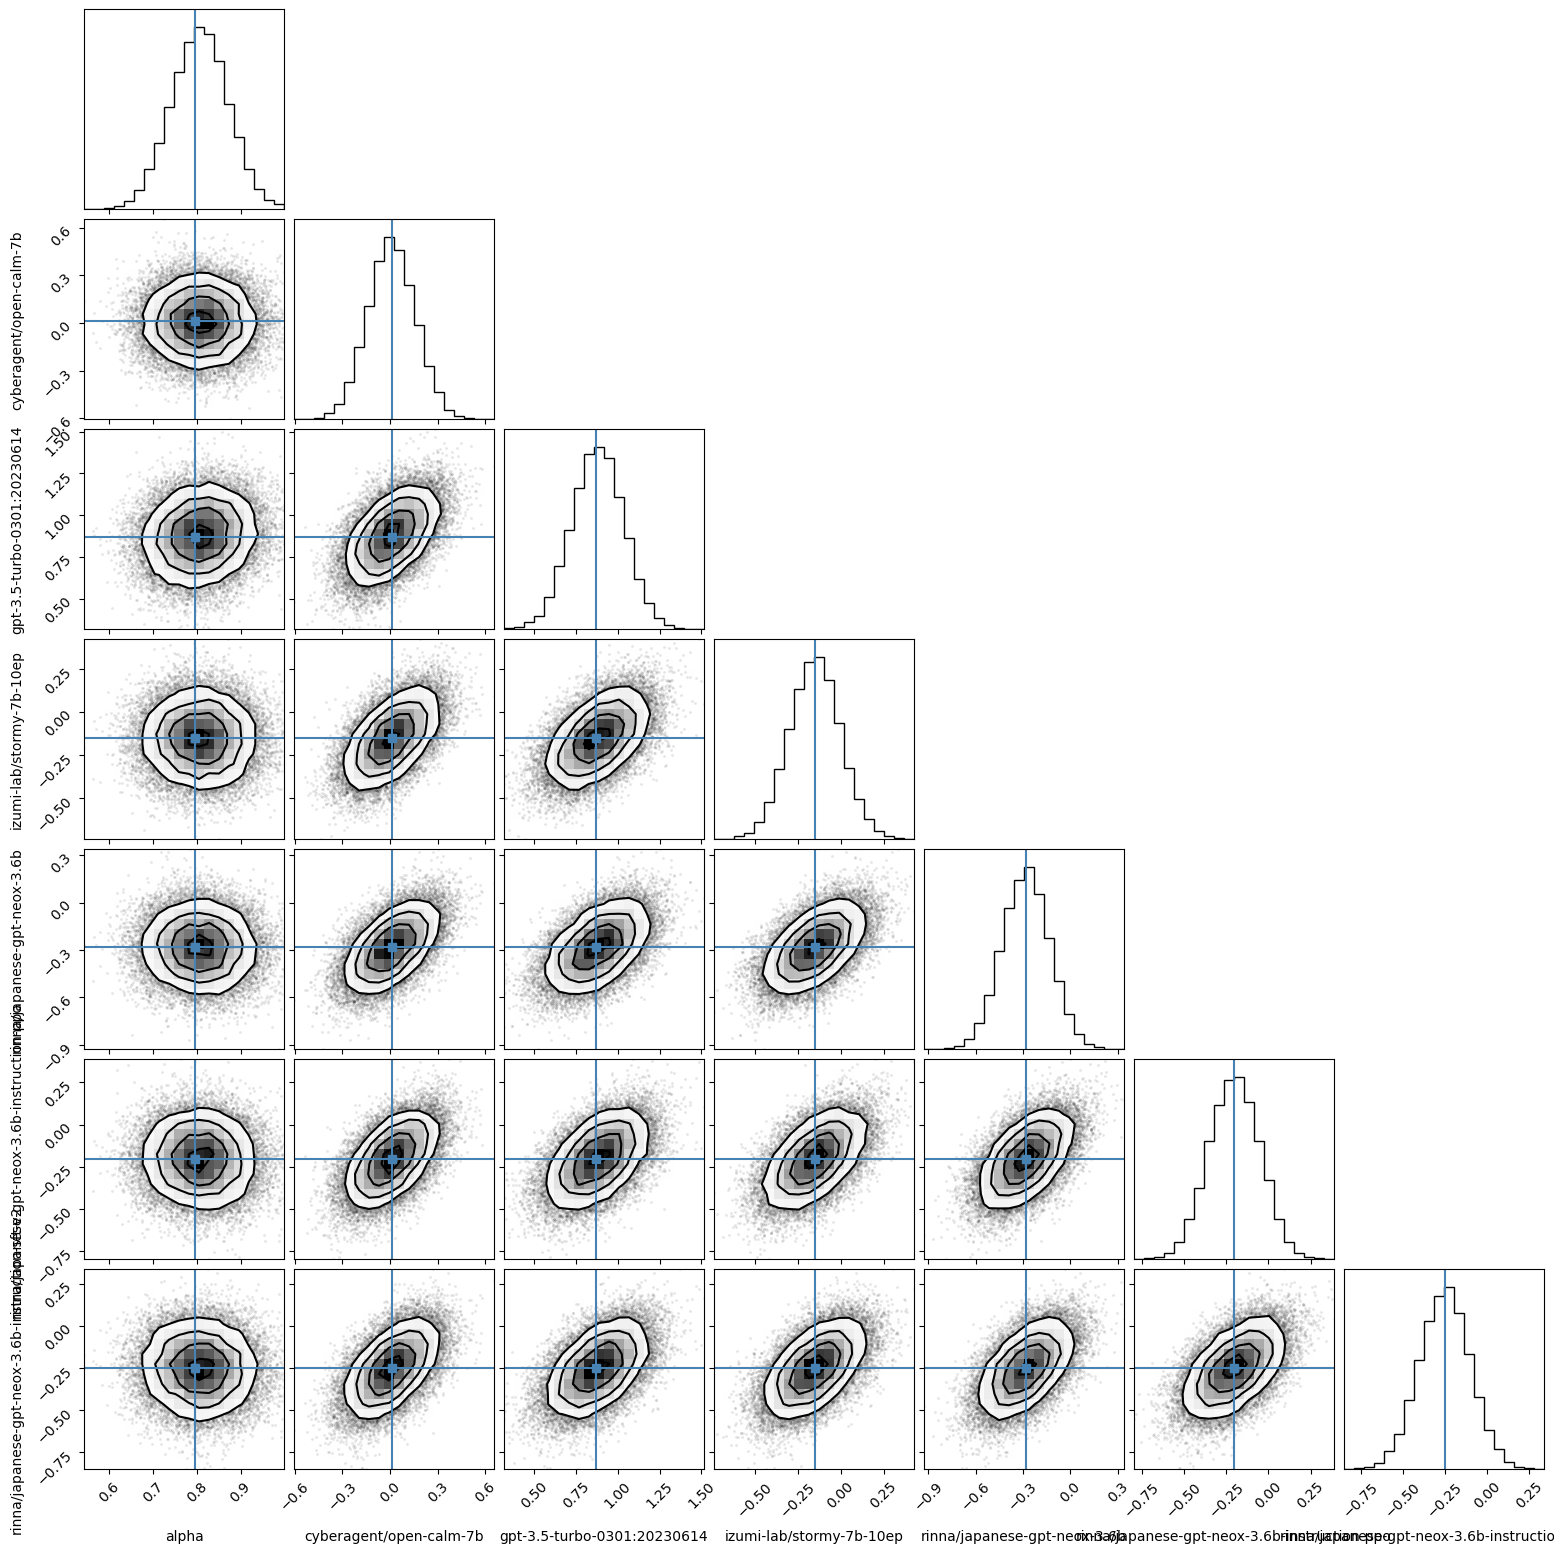

In [60]:
import corner

thin_samples = sampler.get_chain(discard=1000, thin=25, flat=True)

labels = ["alpha"] + [int_to_model[i] for i in range(N)]
fig = corner.corner(thin_samples, labels=labels, truths=max_likelihood.x);

In [61]:
from IPython.display import Math, display

parameters = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    print(mcmc[1], max_likelihood.x[i])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(max_likelihood.x[i], q[0], q[1], labels[i])
    display(Math(txt))

    parameters.append(
        {
            "parameter": labels[i],
            "mle": max_likelihood.x[i],
            "one_sigma_down": q[0],
            "one_sigma_up": q[1],
        }
    )

0.8069445241177912 0.7952772447368117


<IPython.core.display.Math object>

0.009598843912260204 0.009992151273789841


<IPython.core.display.Math object>

0.8798781357726271 0.8719689096442886


<IPython.core.display.Math object>

-0.15150267090243155 -0.14926894028344173


<IPython.core.display.Math object>

-0.28237326931276174 -0.2793585270335402


<IPython.core.display.Math object>

-0.20200292316790136 -0.20418973725382156


<IPython.core.display.Math object>

-0.2503461974999064 -0.24924616833032157


<IPython.core.display.Math object>

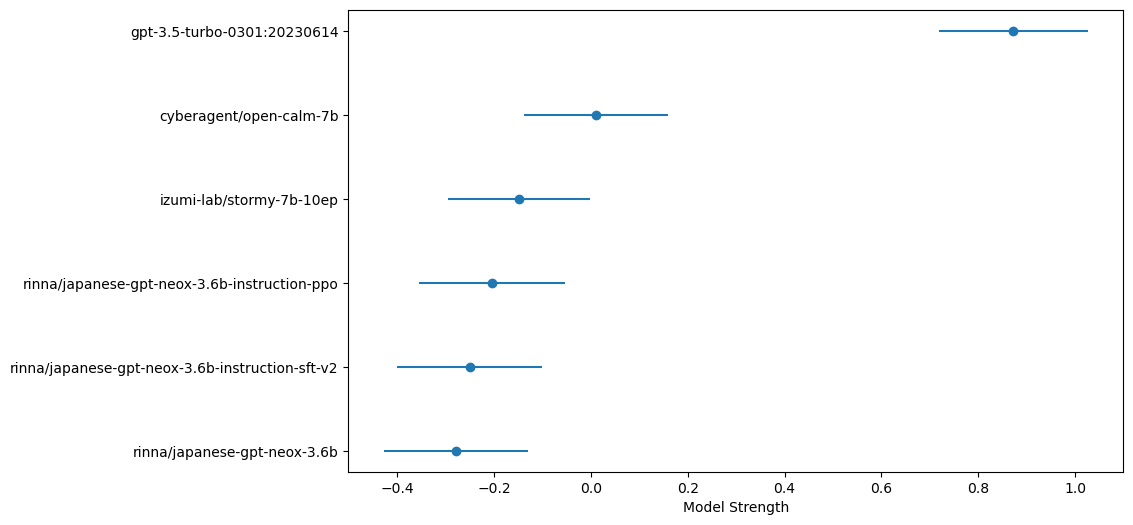

In [62]:
strengths = parameters[1:]
strengths = [{('model_id' if k == 'parameter' else k): v for k, v in d.items()} for d in strengths]

# Sort the models by strength
strengths.sort(key=lambda d: d["mle"])

# Get x values and error values
x_values = [d["mle"] for d in strengths]
errors = np.array([[d["one_sigma_down"], d["one_sigma_up"]] for d in strengths]).T
labels = [d["model_id"] for d in strengths]
y_values = range(len(x_values))

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(x_values, y_values, xerr=errors, fmt="o")
plt.xlabel("Model Strength")
plt.yticks(y_values, labels)
plt.savefig(charts_prefix + "ranking.png")
plt.show()

Note these errors are correlated, and we can calculate statistics for parameter differences (e.g. fraction of samples where model A > model B) 

In [63]:
modelA = 'izumi-lab/stormy-7b-10ep'
modelB = 'rinna/japanese-gpt-neox-3.6b-instruction-ppo'
A_stronger_rate = np.sum(flat_samples[:, model_to_int[modelA]+1] > flat_samples[:, model_to_int[modelB]+1])/len(flat_samples)
print(f'{modelA} is stronger than {modelB} with {A_stronger_rate:.2%} probability')

izumi-lab/stormy-7b-10ep is stronger than rinna/japanese-gpt-neox-3.6b-instruction-ppo with 64.22% probability


## Output standings

In [64]:
output = {
    "date": tournament['date'],
    "model_metadata": tournament['model_metadata'],
    "metadata": tournament['metadata'],
    "ranking": strengths,
}

In [65]:
output_path = f"./rankings/{tournament_file.split('/')[-1].split('.')[0]}.json"

In [66]:
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(output, f, ensure_ascii=False, indent=4)

In [67]:
from registry import StandingsRegistry

registry = StandingsRegistry("./registry/registry.jsonl")
registry.register(output_path)